# Dielectric Constant Parameterization for DEW
The DEW model utilizes two parameterizations of the dielectric constant $\epsilon(T,P)$ of water. The high pressure (> 500 MPa) formulation is taken from:

Sverjensky DA, Harrison B, Azzolini D (2014) Water in the deep Earth: The dielectric constantand the solubilities of quartz and corundumto 60 kb and 1200°C. Geochimica et Cosmochimica Acta 129, 125-145  

The lower pressure formulation is taken from SUPCRT and uses the model developed by:

Johnson JW, Norton D (1991) Critical phenomena in hydrothermal systems: State, thermodynamic, electrostatic, and transport properties of H2O in the critical region. American Journal of Science 291, 541-648

The DEW computational workbook also has a parameterization for $\epsilon$ that applies to the steam saturation curve. That case is ignored in the thermoengine implementation (*born.c* in the *aqueous* module) and in this notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from thermoengine import model

/Users/ghiorso/mambaforge/lib/python3.9/site-packages/numdifftools/multicomplex.py:35: DeprecationWarning: `finfo.machar` is deprecated (NumPy 1.22)
  _TINY = np.finfo(float).machar.tiny
/Users/ghiorso/mambaforge/lib/python3.9/site-packages/numdifftools/extrapolation.py:9: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


## The SWIM model is used to compute the density of water and all density derivatives
Note that Johnson and Norton (1991) calibrate their dielectric constant model using an alternate formulation (Pitzer KS, 1983, Dielectric constant of water at very high temperature and pressure. Proceedings of the National Academy of Sciences 80, 4575-4576), where estimates of $\epsilon$ are derived from teh Kirkwood equation.

In [2]:
Water = model.Database().get_phase('H2O')

In [3]:
def density_gm_cc(Tk=298.15, Pbars=1.0):
    global Water
    v       = 10.0*Water.volume(Tk,Pbars)
    dvdt    = 10.0*Water.volume(Tk, Pbars, deriv={'dT':1})
    dvdp    = 10.0*Water.volume(Tk, Pbars, deriv={'dP':1})
    d2vdt2  = 10.0*Water.volume(Tk, Pbars, deriv={'dT':2})
    d2vdtdp = 10.0*Water.volume(Tk, Pbars, deriv={'dT':1, 'dP':1})
    d2vdp2  = 10.0*Water.volume(Tk, Pbars, deriv={'dP':2})
    MW = Water.props['molwt'][0]
    return np.array([
        MW/v, # rho
        -MW*dvdt/v/v, # d rho / dT
        -MW*dvdp/v/v, # d rho / dP
        MW*(2.0*dvdt*dvdt/v/v/v - d2vdt2/v/v),  # d2 rho / dT2
        MW*(2.0*dvdt*dvdp/v/v/v - d2vdtdp/v/v), # d2 rho / dT dP
        MW*(2.0*dvdp*dvdp/v/v/v - d2vdp2/v/v)   # d2 rho / dP2
        ])
density_gm_cc(Tk=1500, Pbars=1000)

array([ 1.42553454e-01, -1.13491436e-04,  1.36934393e-04,  2.19028108e-07,
       -1.18781835e-07, -1.80883843e-08])

## High-pressure formulation for $\epsilon$ from Sverjensky et al. (2014)

In [4]:
def eps_sverjensky(Tk=1000.0, Pbars=5000.0):
    global density_gm_cc
    tc = Tk - 273.15
    a1 = -0.00157637700752506
    a2 = 0.0681028783422197
    a3 = 0.754875480393944
    b1 = -8.01665106535394E-05
    b2 = -0.0687161761831994
    b3 = 4.74797272182151
                
    rhoExponent = a1 * tc + a2 * np.sqrt(tc) + a3
    expExponent = b1 * tc + b2 * np.sqrt(tc) + b3
    
    swim = density_gm_cc(Tk, Pbars)
    rho = swim[0]
    epsilon = np.exp(expExponent) * np.power(rho, rhoExponent)

    DrhoDt = swim[1]
    DrhoExponentDt = a1 + a2/2.0/np.sqrt(tc)
    DexpExponentDt = b1 + b2/2.0/np.sqrt(tc)
    DepsilonDt = (
        DexpExponentDt*np.exp(expExponent)*np.power(rho, rhoExponent)
        + np.exp(expExponent)*(rhoExponent*np.power(rho, rhoExponent-1.0)*DrhoDt
        + np.power(rho, rhoExponent)*np.log(rho)*DrhoExponentDt)
    )
    
    DrhoDp = swim[2]
    DepsilonDp = np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*DrhoDp
    
    D2rhoDt2 = swim[3]
    D2rhoExponentDt2 = - a2/2.0/2.0/np.power(tc, 3.0/2.0)
    D2expExponentDt2 = - b2/2.0/2.0/np.power(tc, 3.0/2.0)
    DpowOfRowToTheRhoExponent   =       rhoExponent*np.power(rho, rhoExponent-1.0)*DrhoDt + np.power(rho, rhoExponent)    *np.log(rho)*DrhoExponentDt
    DpowOfRowToTheRhoExponentM1 = (rhoExponent-1.0)*np.power(rho, rhoExponent-2.0)*DrhoDt + np.power(rho, rhoExponent-1.0)*np.log(rho)*DrhoExponentDt
    D2epsilonDt2 = (
        D2expExponentDt2*np.exp(expExponent)*np.power(rho, rhoExponent)
        + DexpExponentDt*DexpExponentDt*np.exp(expExponent)*np.power(rho, rhoExponent)
        + DexpExponentDt*np.exp(expExponent)*DpowOfRowToTheRhoExponent
        + DexpExponentDt*np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*DrhoDt
        + np.exp(expExponent)*DrhoExponentDt*np.power(rho, rhoExponent-1.0)*DrhoDt
        + np.exp(expExponent)*rhoExponent*DpowOfRowToTheRhoExponentM1*DrhoDt
        + np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*D2rhoDt2
        + DexpExponentDt*np.exp(expExponent)*np.power(rho, rhoExponent)*np.log(rho)*DrhoExponentDt
        + np.exp(expExponent)*DpowOfRowToTheRhoExponent*np.log(rho)*DrhoExponentDt
        + np.exp(expExponent)*np.power(rho, rhoExponent)*(DrhoDt/rho)*DrhoExponentDt
        + np.exp(expExponent)*np.power(rho, rhoExponent)*np.log(rho)*D2rhoExponentDt2
    )
    
    D2rhoDtDp = swim[4]
    D2epsilonDtDp = (
        DexpExponentDt*np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*DrhoDp
        + np.exp(expExponent)*rhoExponent*(rhoExponent-1.0)*np.power(rho, rhoExponent-2.0)*DrhoDt*DrhoDp
        + np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*D2rhoDtDp
        + np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*np.log(rho)*DrhoExponentDt*DrhoDp
        + np.exp(expExponent)*np.power(rho, rhoExponent-1.0)*DrhoExponentDt*DrhoDp
    )

    D2rhoDp2 = swim[5]
    D2epsilonDp2 = (
        np.exp(expExponent)*rhoExponent*(rhoExponent-1.0)*np.power(rho, rhoExponent-2.0)*DrhoDp*DrhoDp
        + np.exp(expExponent)*rhoExponent*np.power(rho, rhoExponent-1.0)*D2rhoDp2
    )

    return np.array([epsilon, DepsilonDt, DepsilonDp, D2epsilonDt2, D2epsilonDtDp, D2epsilonDp2])
eps_sverjensky()

array([ 1.08377320e+01, -2.55400593e-02,  1.08747327e-03,  7.89375004e-05,
       -1.01560092e-06, -2.00550259e-07])

## Low-pressure formulation for $\epsilon$ from Johnson and Norton (1991)

In [5]:
def eps_johnson_and_norton(Tk=1000.0, Pbars=5000.0):
    T_hat = Tk/298.15
    DT_hatDt = 1.0/298.15
                
    k0 = 1
    k1 = 14.70333593/T_hat
    k2 = 212.8462733/T_hat - 115.4445173 + 19.55210915*T_hat
    k3 = -83.3034798/T_hat + 32.13240048 * T_hat - 6.69409865*T_hat*T_hat
    k4 = -37.86202045/(T_hat*T_hat) + 68.87359646/T_hat - 27.29401652

    swim = density_gm_cc(Tk, Pbars)
    rho = swim[0]

    epsilon = k0 + k1*rho + k2*rho*rho + k3*rho*rho*rho + k4*rho*rho*rho*rho

    DrhoDt = swim[1]
    Dk1Dt = -14.70333593*DT_hatDt/T_hat/T_hat
    Dk2Dt = -212.8462733*DT_hatDt/T_hat/T_hat + 19.55210915*DT_hatDt
    Dk3Dt = 83.3034798*DT_hatDt/T_hat/T_hat + 32.13240048*DT_hatDt - 2.0*6.69409865*T_hat*DT_hatDt
    Dk4Dt = 2.0*37.86202045*DT_hatDt/T_hat/T_hat/T_hat - 68.87359646*DT_hatDt/T_hat/T_hat
    DepsilonDt = (
        Dk1Dt*rho + k1*DrhoDt + Dk2Dt*rho*rho + 2.0*k2*rho*DrhoDt 
        + Dk3Dt*rho*rho*rho + 3.0*k3*rho*rho*DrhoDt + Dk4Dt*rho*rho*rho*rho + 4.0*k4*rho*rho*rho*DrhoDt
    )

    DrhoDp = swim[2]
    DepsilonDp = k1*DrhoDp + 2.0*k2*rho*DrhoDp + 3.0*k3*rho*rho*DrhoDp + 4.0*k4*rho*rho*rho*DrhoDp

    D2rhoDt2 = swim[3]
    D2k1Dt2 = 2.0*14.70333593*DT_hatDt*DT_hatDt/T_hat/T_hat/T_hat
    D2k2Dt2 = 2.0*212.8462733*DT_hatDt*DT_hatDt/T_hat/T_hat/T_hat
    D2k3Dt2 = -2.0*83.3034798*DT_hatDt*DT_hatDt/T_hat/T_hat/T_hat - 2.0*6.69409865*DT_hatDt*DT_hatDt
    D2k4Dt2 = -3.0*2.0*37.86202045*DT_hatDt*DT_hatDt/T_hat/T_hat/T_hat/T_hat + 2.0*68.87359646*DT_hatDt*DT_hatDt/T_hat/T_hat/T_hat
    D2epsilonDt2 = (
        D2k1Dt2*rho + Dk1Dt*DrhoDt
        + Dk1Dt*DrhoDt + k1*D2rhoDt2
        + D2k2Dt2*rho*rho + 2.0*Dk2Dt*rho*DrhoDt
        + 2.0*Dk2Dt*rho*DrhoDt + 2.0*k2*DrhoDt*DrhoDt + 2.0*k2*rho*D2rhoDt2
        + D2k3Dt2*rho*rho*rho + 3.0*Dk3Dt*rho*rho*DrhoDt
        + 3.0*Dk3Dt*rho*rho*DrhoDt + 2.0*3.0*k3*rho*DrhoDt*DrhoDt + 3.0*k3*rho*rho*D2rhoDt2
        + D2k4Dt2*rho*rho*rho*rho + 4.0*Dk4Dt*rho*rho*rho*DrhoDt
        + 4.0*Dk4Dt*rho*rho*rho*DrhoDt + 3.0*4.0*k4*rho*rho*DrhoDt*DrhoDt + 4.0*k4*rho*rho*rho*D2rhoDt2
    )

    D2rhoDtDp = swim[4]
    D2epsilonDtDp = (
        Dk1Dt*DrhoDp + k1*D2rhoDtDp + 2.0*Dk2Dt*rho*DrhoDp + 2.0*k2*DrhoDp*DrhoDt + 2.0*k2*rho*D2rhoDtDp 
        + 3.0*Dk3Dt*rho*rho*DrhoDp 
        + 2.0*3.0*k3*rho*DrhoDp*DrhoDt + 3.0*k3*rho*rho*D2rhoDtDp
        + 4.0*Dk4Dt*rho*rho*rho*DrhoDp 
        + 3.0*4.0*k4*rho*rho*DrhoDp*DrhoDt + 4.0*k4*rho*rho*rho*D2rhoDtDp
    )

    D2rhoDp2 = swim[5]
    D2epsilonDp2 = (
        k1*D2rhoDp2 + 2.0*k2*DrhoDp*DrhoDp + 2.0*k2*rho*D2rhoDp2 
        + 2.0*3.0*k3*rho*DrhoDp*DrhoDp + 3.0*k3*rho*rho*D2rhoDp2 
        + 3.0*4.0*k4*rho*rho*DrhoDp*DrhoDp + 4.0*k4*rho*rho*rho*D2rhoDp2
    )

    return np.array([epsilon, DepsilonDt, DepsilonDp, D2epsilonDt2, D2epsilonDtDp, D2epsilonDp2])
eps_johnson_and_norton()

array([ 1.15451278e+01, -2.45107484e-02,  1.04838464e-03,  6.79603328e-05,
       -1.57856299e-06, -2.36509492e-07])

## Smoothing routine patterned after that used in the SWIM model

Note that two parameters are defined:
- **width_of_DM_to_JN_smooth_interval** - The width (in bars) of the smoothing interval over which the high- and low-pressure models are mixed
- **center_of_DM_to_JN_smooth_interval** - The transition pressure (in bars) between the high- and low-pressure models

In [6]:
width_of_DM_to_JN_smooth_interval  = 1000.0 # bars
center_of_DM_to_JN_smooth_interval = 5000.0 # bars
def smooth_values(p_in, DM_values, JN_values):
    result = []
    p_in = np.atleast_1d(p_in) if np.isscalar(p_in) else p_in
    p_low = p_in[np.where(p_in  < center_of_DM_to_JN_smooth_interval)]
    p_hgh = p_in[np.where(p_in >= center_of_DM_to_JN_smooth_interval)]
    for i,p in enumerate(p_low):
        weight = 1.0/2.0 + np.tanh((p-center_of_DM_to_JN_smooth_interval)/width_of_DM_to_JN_smooth_interval)/2.0
        weightP = 0.0 if weight < 0.001 else weight
        result.append(weightP*DM_values[i] + (1.0-weightP)*JN_values[i])
    for i,p in enumerate(p_hgh):
        weight = 1.0/2.0 - np.tanh((p-center_of_DM_to_JN_smooth_interval)/width_of_DM_to_JN_smooth_interval)/2.0
        weightP = 0.0 if weight < 0.001 else weight
        result.append(weightP*JN_values[i+p_low.size] + (1.0-weightP)*DM_values[i+p_low.size])
        
    return np.array(result)

## Isobaric comparison of $\epsilon$ models at the transition pressure

In [7]:
p = 5000.0
Tk = np.arange(500, 2050, 10)
eps_DM = eps_sverjensky(Tk, p)
eps_JN = eps_johnson_and_norton(Tk, p)

duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0, dx = -2.27725e-14, iter = 45
duanH2ODriver(b): t = 660, p = 2000, z = 0.817976, v = 2.24434, delv = 0,

<function matplotlib.pyplot.show(close=None, block=None)>

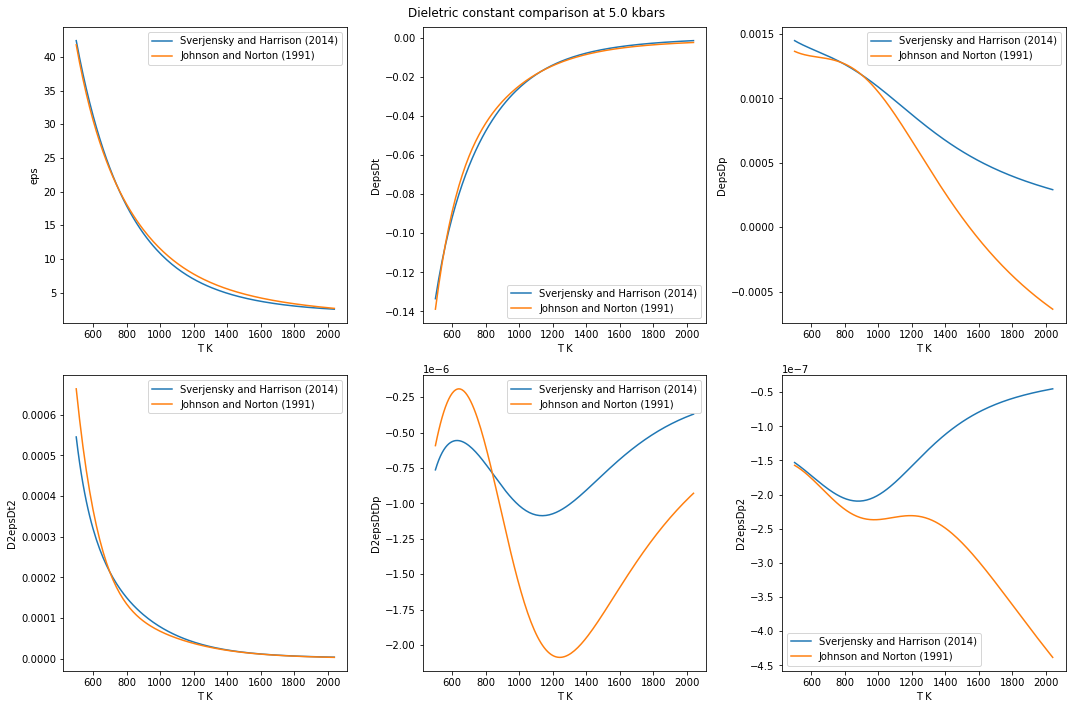

In [8]:
from matplotlib import pyplot as plt 
fig = plt.figure(figsize=(15,10))
fig.suptitle(f'Dieletric constant comparison at {p/1000:.1f} kbars')
plt.subplot(2,3,1)
plt.plot(Tk, eps_DM[0], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[0], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('eps')
plt.legend()
plt.subplot(2,3,2)
plt.plot(Tk, eps_DM[1], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[1], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('DepsDt')
plt.legend()
plt.subplot(2,3,3)
plt.plot(Tk, eps_DM[2], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[2], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('DepsDp')
plt.legend()
plt.subplot(2,3,4)
plt.plot(Tk, eps_DM[3], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[3], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('D2epsDt2')
plt.legend()
plt.subplot(2,3,5)
plt.plot(Tk, eps_DM[4], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[4], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('D2epsDtDp')
plt.legend()
plt.subplot(2,3,6)
plt.plot(Tk, eps_DM[5], label="Sverjensky and Harrison (2014)")
plt.plot(Tk, eps_JN[5], label="Johnson and Norton (1991)")
plt.xlabel('T K')
plt.ylabel('D2epsDp2')
plt.legend()
plt.tight_layout()
plt.show

### Model difference plots

<function matplotlib.pyplot.show(close=None, block=None)>

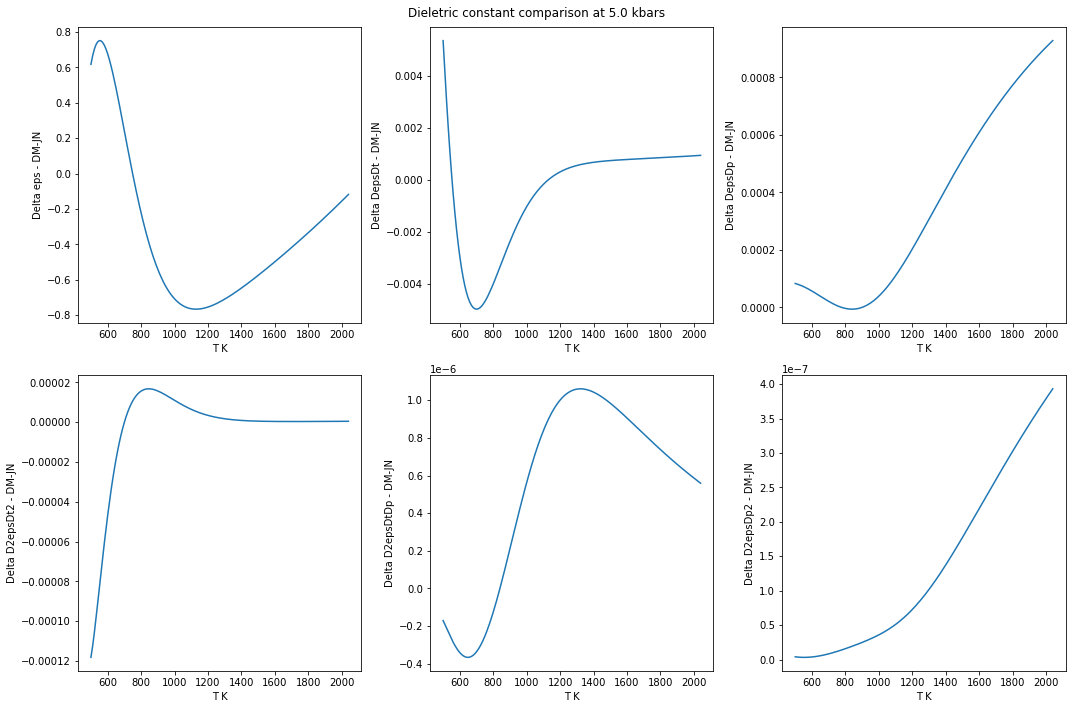

In [9]:
fig = plt.figure(figsize=(15,10))
fig.suptitle(f'Dieletric constant comparison at {p/1000:.1f} kbars')
plt.subplot(2,3,1)
plt.plot(Tk, eps_DM[0]-eps_JN[0])
plt.xlabel('T K')
plt.ylabel('Delta eps - DM-JN')
plt.subplot(2,3,2)
plt.plot(Tk, eps_DM[1]-eps_JN[1])
plt.xlabel('T K')
plt.ylabel('Delta DepsDt - DM-JN')
plt.subplot(2,3,3)
plt.plot(Tk, eps_DM[2]-eps_JN[2])
plt.xlabel('T K')
plt.ylabel('Delta DepsDp - DM-JN')
plt.subplot(2,3,4)
plt.plot(Tk, eps_DM[3]-eps_JN[3])
plt.xlabel('T K')
plt.ylabel('Delta D2epsDt2 - DM-JN')
plt.subplot(2,3,5)
plt.plot(Tk, eps_DM[4]-eps_JN[4])
plt.xlabel('T K')
plt.ylabel('Delta D2epsDtDp - DM-JN')
plt.subplot(2,3,6)
plt.plot(Tk, eps_DM[5]-eps_JN[5])
plt.xlabel('T K')
plt.ylabel('Delta D2epsDp2 - DM-JN')
plt.tight_layout()
plt.show

## Isothermal comparison of $\epsilon$ models as a fumnction of pressure
Also plotted are estimates of the smoothed dielectric function

In [10]:
Tk = 1073.15
p = np.arange(500, 10000, 100)
eps_DM = eps_sverjensky(Tk, p)
eps_JN = eps_johnson_and_norton(Tk, p)

dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38
dewH2ODriver(b): t = 1073, p = 8800, z = 2.11395, v = 2.14312, delv = 0, iter = 38


<function matplotlib.pyplot.show(close=None, block=None)>

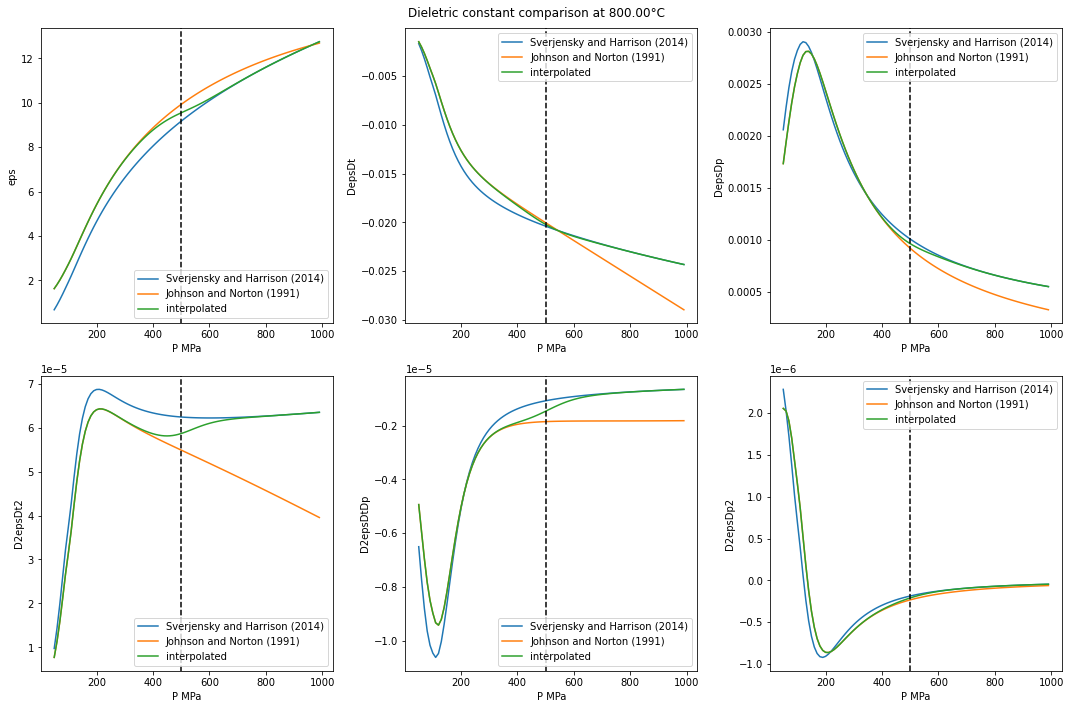

In [11]:
fig = plt.figure(figsize=(15,10))
fig.suptitle(f'Dieletric constant comparison at {Tk-273.15:.2f}°C')
plt.subplot(2,3,1)
plt.plot(p/10, eps_DM[0], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[0], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[0], eps_JN[0]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('eps')
plt.legend()
plt.subplot(2,3,2)
plt.plot(p/10, eps_DM[1], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[1], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[1], eps_JN[1]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('DepsDt')
plt.legend()
plt.subplot(2,3,3)
plt.plot(p/10, eps_DM[2], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[2], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[2], eps_JN[2]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('DepsDp')
plt.legend()
plt.subplot(2,3,4)
plt.plot(p/10, eps_DM[3], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[3], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[3], eps_JN[3]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('D2epsDt2')
plt.legend()
plt.subplot(2,3,5)
plt.plot(p/10, eps_DM[4], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[4], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[4], eps_JN[4]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('D2epsDtDp')
plt.legend()
plt.subplot(2,3,6)
plt.plot(p/10, eps_DM[5], label="Sverjensky and Harrison (2014)")
plt.plot(p/10, eps_JN[5], label="Johnson and Norton (1991)")
plt.plot(p/10, smooth_values(p, eps_DM[5], eps_JN[5]), label='interpolated')
plt.axvline(x=500, color='k', linestyle='--')
plt.xlabel('P MPa')
plt.ylabel('D2epsDp2')
plt.legend()
plt.tight_layout()
plt.show

## Import C-implementation from thermoengine

In [12]:
from thermoengine import aqueous

In [16]:
t = 1000
p = np.arange(500, 10000, 100)
eps_DM = eps_sverjensky(t, p)
eps_JN = eps_johnson_and_norton(t, p)
eps_SM = []
for i in range(0,6):
    eps_SM.append(smooth_values(p, eps_DM[i], eps_JN[i])[45])
p = 5000
eps_aq = [
    aqueous.cy_DEW_epsilon(t,p),
    aqueous.cy_DEW_dEpsilonDt(t,p),
    aqueous.cy_DEW_dEpsilonDp(t,p),
    aqueous.cy_DEW_d2EpsilonDt2(t,p),
    aqueous.cy_DEW_d2EpsilonDtDp(t,p),
    aqueous.cy_DEW_d2EpsilonDp2(t,p)
]
eps_DM = eps_sverjensky(t,p)
print ('Sverjensky et al. (2014) model:')
for i,x in enumerate(['eps', 'DepsDt', 'DepsDp', 'D2epsDt2', 'D2epsDtDp', 'D2epsDp2']):
    print (f'{x:<9s} {eps_DM[i]:13.6e} (aqueous) {eps_aq[i]:13.6e} (% diff) {50*(eps_DM[i]-eps_aq[i])/(eps_DM[i]+eps_aq[i]):10.6f}')
eps_JN = eps_johnson_and_norton(t,p)
print ('Johnson and Norton (1991) model:')
for i,x in enumerate(['eps', 'DepsDt', 'DepsDp', 'D2epsDt2', 'D2epsDtDp', 'D2epsDp2']):
    print (f'{x:<9s} {eps_JN[i]:13.6e} (aqueous) {eps_aq[i]:13.6e} (% diff) {50*(eps_JN[i]-eps_aq[i])/(eps_JN[i]+eps_aq[i]):10.6f}')
print ('Smoothed model:')
for i,x in enumerate(['eps', 'DepsDt', 'DepsDp', 'D2epsDt2', 'D2epsDtDp', 'D2epsDp2']):
    print (f'{x:<9s} {eps_SM[i]:13.6e} (aqueous) {eps_aq[i]:13.6e} (% diff) {50*(eps_SM[i]-eps_aq[i])/(eps_SM[i]+eps_aq[i]):10.6f}')

Sverjensky et al. (2014) model:
eps        1.083773e+01 (aqueous)  1.119150e+01 (% diff)  -0.802947
DepsDt    -2.554006e-02 (aqueous) -2.502560e-02 (% diff)   0.508705
DepsDp     1.087473e-03 (aqueous)  1.067934e-03 (% diff)   0.453252
D2epsDt2   7.893750e-05 (aqueous)  7.344940e-05 (% diff)   1.800712
D2epsDtDp -1.015601e-06 (aqueous) -1.297097e-06 (% diff)  -6.085879
D2epsDp2  -2.005503e-07 (aqueous) -2.185315e-07 (% diff)  -2.145319
Johnson and Norton (1991) model:
eps        1.154513e+01 (aqueous)  1.119150e+01 (% diff)   0.777665
DepsDt    -2.451075e-02 (aqueous) -2.502560e-02 (% diff)  -0.519669
DepsDp     1.048385e-03 (aqueous)  1.067934e-03 (% diff)  -0.461882
D2epsDt2   6.796033e-05 (aqueous)  7.344940e-05 (% diff)  -1.940838
D2epsDtDp -1.578563e-06 (aqueous) -1.297097e-06 (% diff)   4.893939
D2epsDp2  -2.365095e-07 (aqueous) -2.185315e-07 (% diff)   1.975421
Smoothed model:
eps        1.119143e+01 (aqueous)  1.119150e+01 (% diff)  -0.000153
DepsDt    -2.502540e-02 (aqueous) -